In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

from neural_compressor import QuantizationAwareTrainingConfig
from neural_compressor.training import prepare_compression

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\t255 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tMore checkpoints.\n' +
            '\tQAT with Neural Compressor.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

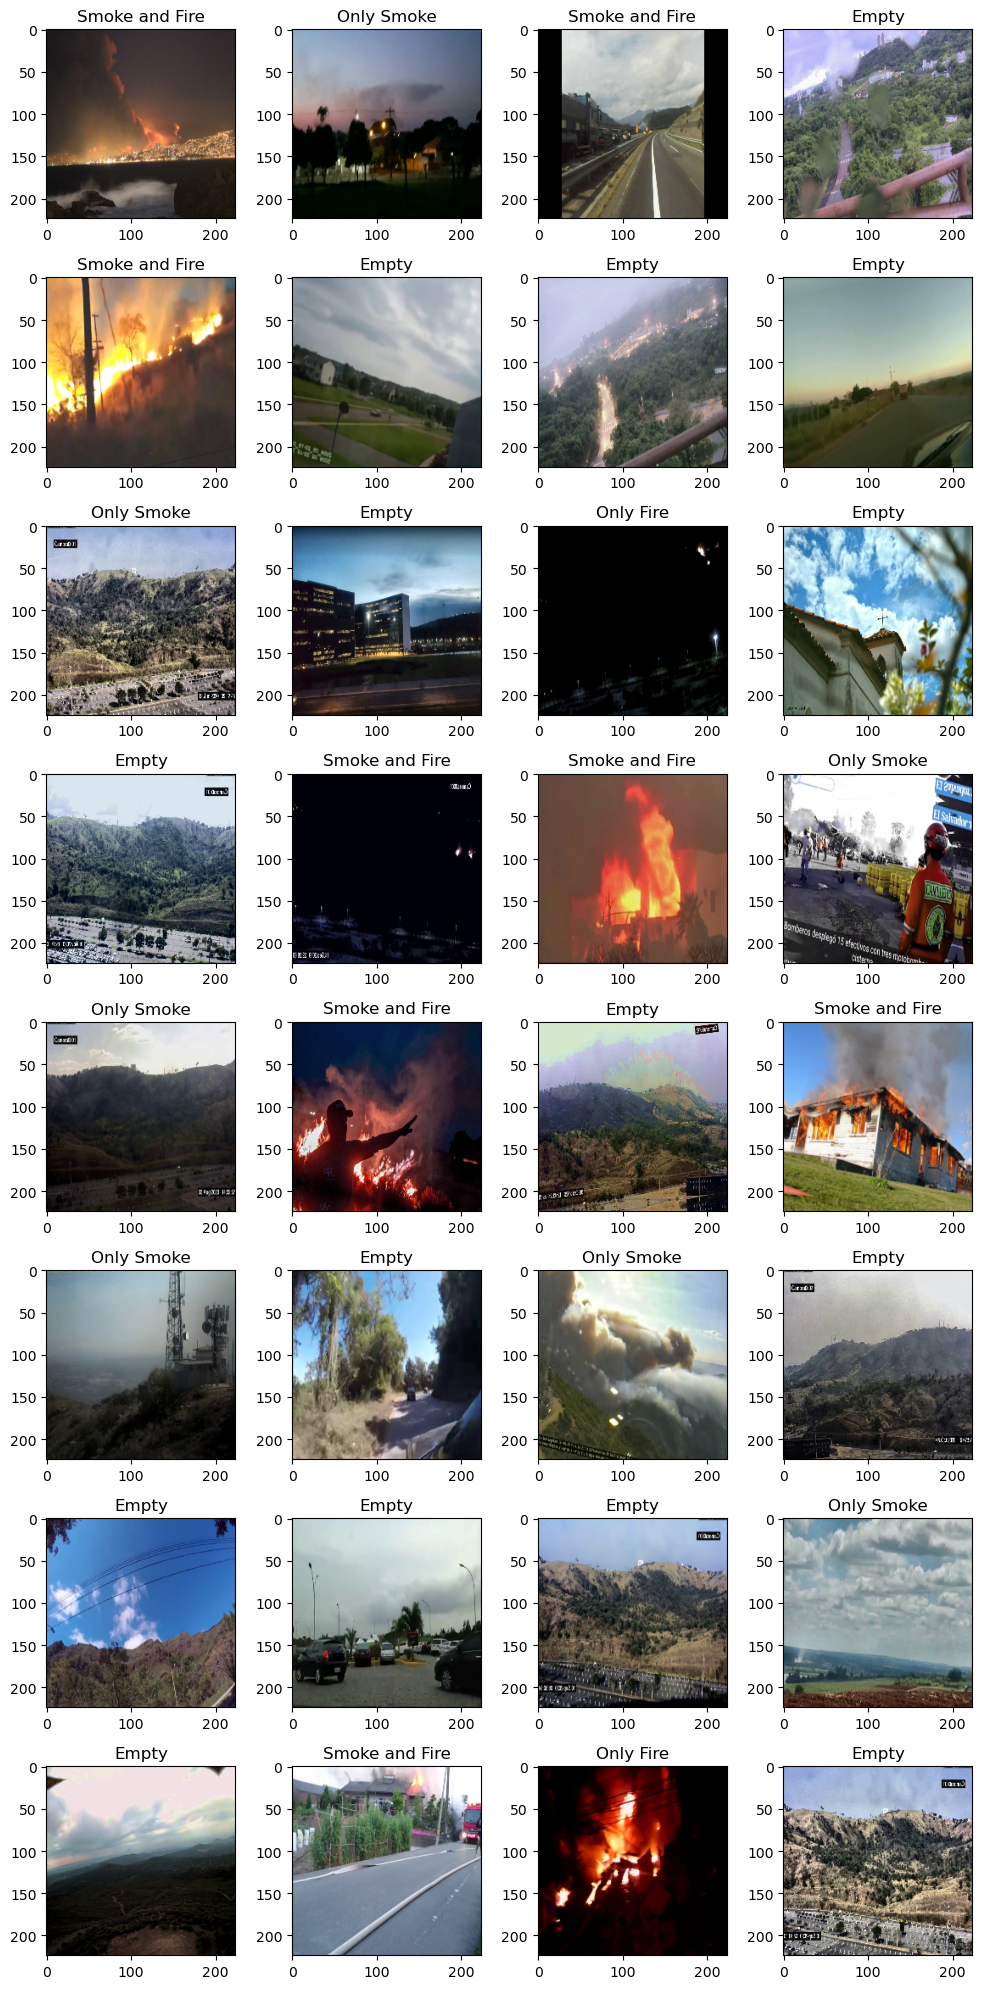

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'\tTrain dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("TEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'\tTest dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [8]:
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)   
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(fp32_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in fp32_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(fp32_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 93266
Total parameters = 93266



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = fp32_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{fp32_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{fp32_model}')

Model shape is tensor([[ 0.0724, -0.1167],
        [ 0.0984, -0.0883],
        [ 0.1928,  0.0420],
        [ 0.1430, -0.0193]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn31)

# Torchinfo: model summary

### FP32 Model

In [10]:
print(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 224, 224]        64
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-4                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 16, 112, 112]        4,608
│    └─BatchNorm2d: 2-7                  [64, 16, 112, 112]        32
│    └─ReLU: 2-8                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-9                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-10                   [64, 16, 56, 56]          --
│    └─Conv2d: 2-11                      [64, 16, 56, 56]          256
│    └─Bat

# Load Model

In [11]:
model_path = 'BED_classifier__smoke__precision=0.9123__recall=0.9127__epoch=133.pt'
epoch_saved = utils.load_checkpoint(model_path, fp32_model, optimizer, scheduler, config.DEVICE)

Loading Model. Trained during 133 epochs


# Loss Function

In [12]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [13]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Optimizer Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 1e-05
Weight Decay: 1e-05
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [14]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [15]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr:.6f}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [16]:
if __name__ == "__main__":
       
    # set CPU
    fp32_model.to('cpu')
    conf = QuantizationAwareTrainingConfig()
    compression_manager = prepare_compression(fp32_model, conf)
    compression_manager.callbacks.on_train_begin()
    model = compression_manager.model
    
    # set GPU
    model.to(config.DEVICE)
    quant_model = train_loop(model)
    
    # set CPU
    model.to('cpu')
    quant_model.to('cpu')
    compression_manager.callbacks.on_train_end()
    compression_manager.save("./output")

/opt/conda/envs/pytorch_light/lib/python3.10/site-packages/torch/ao/quantization/fx/fuse.py:56: UserWarning: Passing a fuse_custom_config_dict to fuse is deprecated and will not be supported in a future version. Please pass in a FuseCustomConfig instead.
  warnings.warn(
2024-06-25 22:56:11 [INFO] Attention Blocks: 0
2024-06-25 22:56:11 [INFO] FFN Blocks: 0
/opt/conda/envs/pytorch_light/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(



***Start Training: 22:56:11


=== EPOCH 0/9 ===
Learning Rate = 2.2517998136852506e-05



Training:   0%|                                         | 0/269 [00:00<?, ?it/s]/opt/conda/envs/pytorch_light/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/envs/pytorch_light/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(
Training: 100%|███████████████████████████████| 269/26

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.298      |15.997      |7.301       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.152      |13.226      |6.926       
SMOKE -> Precision: 0.911 - Recall: 0.907 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.944 - Recall: 0.912 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 20.152

Saving model with new best smoke precision: 0.911

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 1/9 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.915      |15.802      |7.113       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.032      |13.198      |6.834       
SMOKE -> Precision: 0.907 - Recall: 0.904 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.937 - Recall: 0.915 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 20.032

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 2/9 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.986      |15.767      |7.219       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.023      |13.210      |6.813       
SMOKE -> Precision: 0.908 - Recall: 0.914 - Accuracy: 0.914 - F1: 0.911
FIRE -> Precision: 0.936 - Recall: 0.921 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 20.023

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 3/9 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.390      |15.921      |7.468       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.042      |13.209      |6.834       
SMOKE -> Precision: 0.908 - Recall: 0.910 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.937 - Recall: 0.920 - Accuracy: 0.963 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 4/9 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.836      |16.102      |6.733       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.316      |13.331      |6.985       
SMOKE -> Precision: 0.909 - Recall: 0.893 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.944 - Recall: 0.915 - Accuracy: 0.964 - F1: 0.930

=== EPOCH 5/9 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.156      |16.024      |7.132       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.068      |13.139      |6.929       
SMOKE -> Precision: 0.912 - Recall: 0.898 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.943 - Recall: 0.919 - Accuracy: 0.965 - F1: 0.931

Saving model with new best smoke precision: 0.912

=== EPOCH 6/9 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.949      |15.719      |7.231       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.337      |13.273      |7.064       
SMOKE -> Precision: 0.919 - Recall: 0.885 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.940 - Recall: 0.910 - Accuracy: 0.962 - F1: 0.925

Saving model with new best smoke precision: 0.919

=== EPOCH 7/9 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.855      |15.680      |7.175       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.132      |13.244      |6.888       
SMOKE -> Precision: 0.910 - Recall: 0.902 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.941 - Recall: 0.923 - Accuracy: 0.965 - F1: 0.932

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 8/9 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.951      |15.808      |7.142       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.338      |13.330      |7.008       
SMOKE -> Precision: 0.909 - Recall: 0.903 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.938 - Recall: 0.921 - Accuracy: 0.964 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 9/9 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|███████████████████████████████| 269/269 [00:24<00:00, 10.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.089      |15.916      |7.174       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.236      |13.239      |6.997       
SMOKE -> Precision: 0.914 - Recall: 0.900 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.937 - Recall: 0.914 - Accuracy: 0.962 - F1: 0.925


2024-06-25 23:00:56 [INFO] |******Mixed Precision Statistics******|
2024-06-25 23:00:56 [INFO] +----------------------+-------+-------+
2024-06-25 23:00:56 [INFO] |       Op Type        | Total |  INT8 |
2024-06-25 23:00:56 [INFO] +----------------------+-------+-------+
2024-06-25 23:00:56 [INFO] | quantize_per_tensor  |   4   |   4   |
2024-06-25 23:00:56 [INFO] |      ConvReLU2d      |   12  |   12  |
2024-06-25 23:00:56 [INFO] |      dequantize      |   4   |   4   |
2024-06-25 23:00:56 [INFO] |      MaxPool2d       |   3   |   3   |
2024-06-25 23:00:56 [INFO] |  AdaptiveAvgPool2d   |   1   |   1   |
2024-06-25 23:00:56 [INFO] |       Dropout        |   1   |   1   |
2024-06-25 23:00:56 [INFO] |      LinearReLU      |   1   |   1   |
2024-06-25 23:00:56 [INFO] |        Linear        |   1   |   1   |
2024-06-25 23:00:56 [INFO] +----------------------+-------+-------+
2024-06-25 23:00:56 [INFO] Training finished!
2024-06-25 23:00:56 [INFO] Save config file and weights of quantized m


Saving model with precision > 0.9 and recall > 0.9

***Script finished: 23:00:56

Time elapsed: 0:04:45.263851


In [21]:
from neural_compressor.config import Torch2ONNXConfig

int8_onnx_config = Torch2ONNXConfig(
    dtype="int8",
    opset_version=14,
    quant_format="QOperator",  # or QDQ
    example_inputs=torch.randn(1, 3, 224, 224),
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)
quant_model.export(config.RUN_FOLDER + "int8-model-bnAffine_qat_v1.onnx", int8_onnx_config)
model.export(config.RUN_FOLDER + "int8-model-bnAffine_qat_v2.onnx", int8_onnx_config)

2024-06-25 23:07:44 [INFO] **********************************************************************************************
2024-06-25 23:07:44 [INFO] The INT8 ONNX Model exported to path: experiments/v0_no_Tuning/int8-model-bnAffine_qat_v1.onnx
2024-06-25 23:07:44 [INFO] **********************************************************************************************
2024-06-25 23:07:44 [INFO] **********************************************************************************************
2024-06-25 23:07:44 [INFO] The INT8 ONNX Model exported to path: experiments/v0_no_Tuning/int8-model-bnAffine_qat_v2.onnx
2024-06-25 23:07:44 [INFO] **********************************************************************************************


In [22]:
print(quant_model)

PyTorchFXModel(
  (_model): GraphModule(
    (model): Module(
      (conv1): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.08690787106752396, zero_point=0, padding=(1, 1))
      (dropout1): Dropout2d(p=0.3, inplace=False)
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): QuantizedConvReLU2d(32, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.09051308780908585, zero_point=0, padding=(1, 1))
      (dropout2): Dropout2d(p=0.3, inplace=False)
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv31): QuantizedConvReLU2d(16, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.07281135767698288, zero_point=0)
      (conv32): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.12436161190271378, zero_point=0, padding=(1, 1))
      (conv33): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1, 1), scale=0.1094081774353981, zero_point=0)
      (c